In [24]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit
import sys

from sklearn.model_selection import ParameterGrid

In [58]:
sys.setrecursionlimit(10**7)
inp_data = pd.read_csv('testData/AUDCAD.csv', index_col=1)
inp_data.index = pd.to_datetime(inp_data.index)
#inp_data.resample('1T').first()
inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

inp_data

,open,high,low,close
time,,,,
2018-11-01 00:15:00,0.931100,0.931135,0.930670,0.931025
2018-11-01 00:16:00,0.931025,0.931100,0.930965,0.931065
2018-11-01 00:17:00,0.931065,0.931120,0.930935,0.931090
2018-11-01 00:18:00,0.931090,0.931250,0.931090,0.931145
2018-11-01 00:19:00,0.931145,0.931175,0.931115,0.931115
...,...,...,...,...
2021-11-13 00:55:00,0.919965,0.920050,0.919885,0.919965
2021-11-13 00:56:00,0.919965,0.920120,0.919885,0.920035
2021-11-13 00:57:00,0.920035,0.920035,0.919930,0.919935


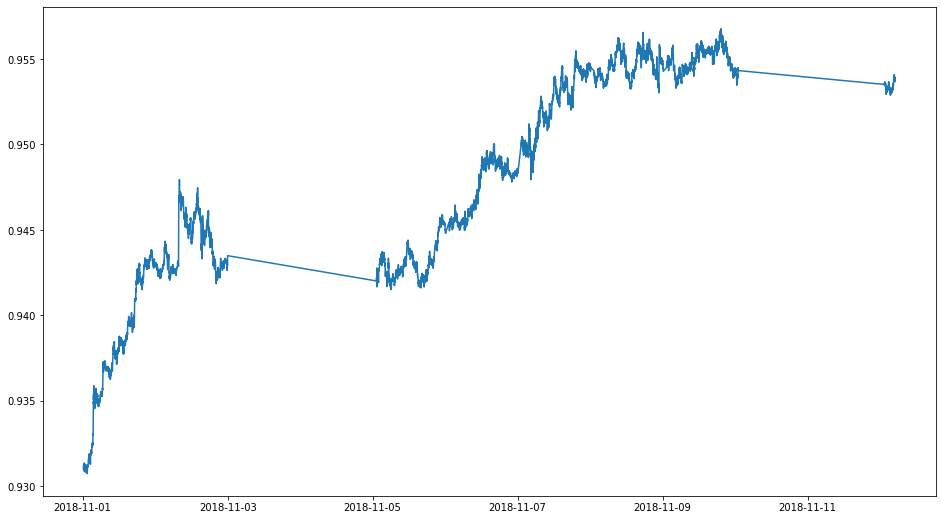

In [85]:
plt.figure(figsize=(16,9))
plt.plot(inp_data.iloc[:10000].close)
plt.show()
global DataFrequency

DataFrequency = '1T'
def create_grid(pam_grid_obj):
    CAP = 100_000
    slippage = 10
    BuyLossPercent = pam_grid_obj['BuyLossPercent']
    SellLossPercent = pam_grid_obj['BuyLossPercent']
    BuyTakePercent = pam_grid_obj['BuyTakePercent']
    SellTakePercent = pam_grid_obj['BuyTakePercent']
    MaxHold = pam_grid_obj['MaxHold']
    WindowRoll = pam_grid_obj['WindowRoll']
    Y_STD = pam_grid_obj['Y_STD']


    # Массив параметров
    PARAMS = {'Capital': CAP,
              'slippage': slippage,
              'slippagePerCap': slippage / CAP,
              'window_rolling': WindowRoll,
              'Y_threshold': Y_STD,
              'max_hold_period': MaxHold,
              'stopLossesPercent':{
                  'BuyLossPercent': BuyLossPercent / 100,
                  'SellLossPercent': SellLossPercent / 100,
              },
              'takePercent':{
                  'SellTakePercent': BuyTakePercent / 100,
                  'BuyTakePercent': SellTakePercent / 100,
              },
              'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
              'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
              }
    del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
    return PARAMS

params = {"BuyLossPercent": 1,
#"SellLossPercent": [20, 30, 40],
"BuyTakePercent": 1,
#"SellTakePercent": [20, 30, 40],
"MaxHold": '360T',
"WindowRoll": '120T',
"Y_STD": 200}
paramsDict = create_grid(params)

In [65]:
def calculate_max_drawdown(PNL_SERIES, dollars=True):
    dropout_df = PNL_SERIES.to_frame('pnl')
    dropout_df['hwm'] = dropout_df.expanding().max()
    df0 = dropout_df.groupby('hwm').min().reset_index()
    df0.columns = ['hwm', 'min']
    df0 = df0[df0['hwm'] > df0['min']]
    if dollars:
        dd = df0['hwm'] - df0['min']
    else:
        dd = df0['min'] / df0['hwm']

    return max(dd)

def _estimator(data_frame, params_dict, show=False):
    DF_lines = []
    save_frame = data_frame.copy()
    # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

    # Скользящее среднее
    data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

    # Скользящее отклонение
    data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

    # Отсечение данных имеющих
    # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

    # Верхний уровень BBand
    data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

    # Нижний уровень BBand
    data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

    # Добавление номера линии для удобства
    data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


    # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
    # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
    ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
    ab = pd.DataFrame(ab)
    # print('AB',len(ab))
    # print('DF',len(data_frame))
    ab.columns = ['value', 'time']
    ab.index = ab.time
    ab = ab.drop(['time'], axis=1)

    correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
    # print('CB',len(correct_borders))
    dot_low_tuple = tuple(data_frame.low)
    dot_high_tuple = tuple(data_frame.high)
    dot_close_tuple = tuple(data_frame.close)
    LowBBand_tuple = tuple(data_frame.LowBBand)
    HighBBand_tuple = tuple(data_frame.HighBBand)

    cycle_buffer = -10
    ISX = 0
    if show:
        tqdm_bar = tqdm(total=data_frame.shape[0])

    while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
        openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                     LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                     arrow_index=ISX, openParams=paramsDict, correct_borders=correct_borders)

        openLogic['open_time'] = data_frame.index[openLogic['open_index']]
        closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                        dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                        holdParams=paramsDict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0)

        closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
        summary_dict = openLogic | closeLogic
        DF_lines.append(summary_dict)

        cycle_buffer = ISX
        ISX = closeLogic['close_index']
        if show:
            tqdm_bar.update(ISX - tqdm_bar.last_print_n)

    dfResults = pd.DataFrame(DF_lines)
    dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - paramsDict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - paramsDict["slippage"]
    dfResults.index = dfResults.close_time
    pnl_series = dfResults["profit"].cumsum()


    optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
    return [dfResults, data_frame, optimizePar]

def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders):
    """
    Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
    :param current_dot:
    :param arrow_index:
    :return:
    """
    # Задается вид словаря описывающего информацию об открытии сделки
    ret_dict = {'type_operation': None,
                'position': None,
                'open_price': None,
                'open_index': None,
                'stop_loss_border': None,
                'take_profit_border': None
                }
    # Проверка о пересечении нижней границы
    if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index]):
        ret_dict['type_operation'] = 'SELL'
        ret_dict['position'] = -1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
        ret_dict['open_price'] = LowBBand_tuple[arrow_index]
        ret_dict['open_index'] = arrow_index
        ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
        ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
        return ret_dict
    # Проверка о пересечении верхней границы
    if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index]):
        ret_dict['type_operation'] = 'BUY'
        ret_dict['position'] = (openParams['Capital'] / HighBBand_tuple[arrow_index])
        ret_dict['open_price'] = HighBBand_tuple[arrow_index]
        ret_dict['open_index'] = arrow_index
        ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
        ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)
        return ret_dict
    else:
        return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                            LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                            arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders)

def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index, time_border_counter):
    if open_logic['type_operation'] == 'BUY':
        if time_border_counter - 1 > holdParams['time_barrier_param']:
            return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
        elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
            return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
        elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
            return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}

        else:
            return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                   dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                   arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

    if open_logic['type_operation'] == 'SELL':
        if time_border_counter - 1 > holdParams['time_barrier_param']:
            return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
        elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
            return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}
        elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
            return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
        else:
            return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                   dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                   arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

In [61]:
SHIFT = 500_000
df, preprocessed_data, optimizePar = _estimator(data_frame=inp_data.copy().iloc[:SHIFT], params_dict=paramsDict, show=True)

def plotter(test_df, qqq):
    plt.figure(figsize=(16,16))
    plt.subplot(4,1,1)
    plt.step(test_df.open_time, test_df.profit.cumsum().values)
    plt.subplot(4,1,2)
    plt.plot(qqq.open, label='open', alpha=.5)
    plt.plot(qqq.high, label='high', alpha=.7, color='red')
    plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
    plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
    plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
    plt.legend(loc='lower right')
    plt.subplot(4,1,3)
    for _ in range(test_df.shape[0]):
        if test_df.iloc[_].type_operation == 'BUY':
            plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
            plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
        if test_df.iloc[_].type_operation == 'SELL':
            plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
            plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
        plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
    plt.subplot(4,1,4)
    # plt.plot(qqq.index, [1 if x else 0 for x in correct_borders])
    plt.show()

# plotter(df, preprocessed_data)

AB 726617
DF 500000
CB 500000


  0%|          | 0/500000 [00:00<?, ?it/s]

In [66]:
params = {"BuyLossPercent": np.linspace(.5, 5, 4),
#"SellLossPercent": [20, 30, 40],
"BuyTakePercent": np.linspace(.5, 5, 4),
#"SellTakePercent": [20, 30, 40],
"MaxHold": [str(x)+'T' for x in np.linspace(100, 900, 6)],
"WindowRoll": [str(x)+'T' for x in np.linspace(100, 900, 6)],
"Y_STD": np.linspace(10, 300, 6)}
grid = ParameterGrid(params,)
shuffled = pd.DataFrame(grid).sample(frac=1, random_state=0).reset_index(drop=True)

RESULT = Parallel(n_jobs=1, verbose=5)(delayed(_estimator)(inp_data.copy().iloc[:SHIFT], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:100].shape[0])))

  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.1min finished


  0%|          | 0/500000 [00:00<?, ?it/s]

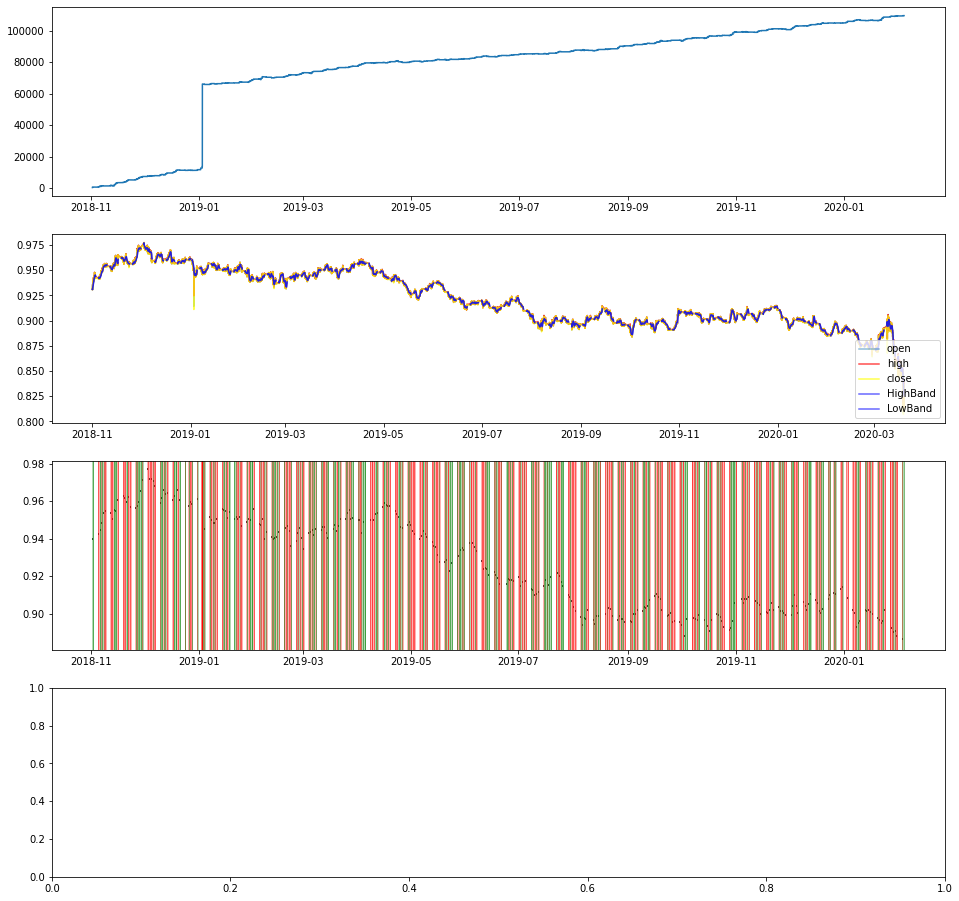

In [72]:
optParams = [_[2] for _ in RESULT]
optParams = shuffled.iloc[optParams.index(max(optParams))]
df, preprocessed_data, optimizePar = _estimator(data_frame=inp_data.copy().iloc[:SHIFT], params_dict=create_grid(dict(optParams)), show=True)
plotter(df, preprocessed_data)

array(['endPeriod', 'takeProfit'], dtype=object)

In [ ]:
plotter(df.loc['2019-02':], preprocessed_data.loc['2019-02':])

{'Capital': 100000,
 'slippage': 0,
 'slippagePerCap': 0.0,
 'window_rolling': '740.0T',
 'Y_threshold': 10.0,
 'max_hold_period': '900.0T',
 'stopLossesPercent': {'BuyLossPercent': 0.035, 'SellLossPercent': 0.035},
 'takePercent': {'SellTakePercent': 0.05, 'BuyTakePercent': 0.05},
 'shift_param': 740,
 'time_barrier_param': 900}

In [86]:
create_grid(dict(optParams))

{'Capital': 100000,
 'slippage': 10,
 'slippagePerCap': 0.0001,
 'window_rolling': '740.0T',
 'Y_threshold': 10.0,
 'max_hold_period': '900.0T',
 'stopLossesPercent': {'BuyLossPercent': 0.035, 'SellLossPercent': 0.035},
 'takePercent': {'SellTakePercent': 0.05, 'BuyTakePercent': 0.05},
 'shift_param': 740,
 'time_barrier_param': 900}

  0%|          | 0/626545 [00:00<?, ?it/s]

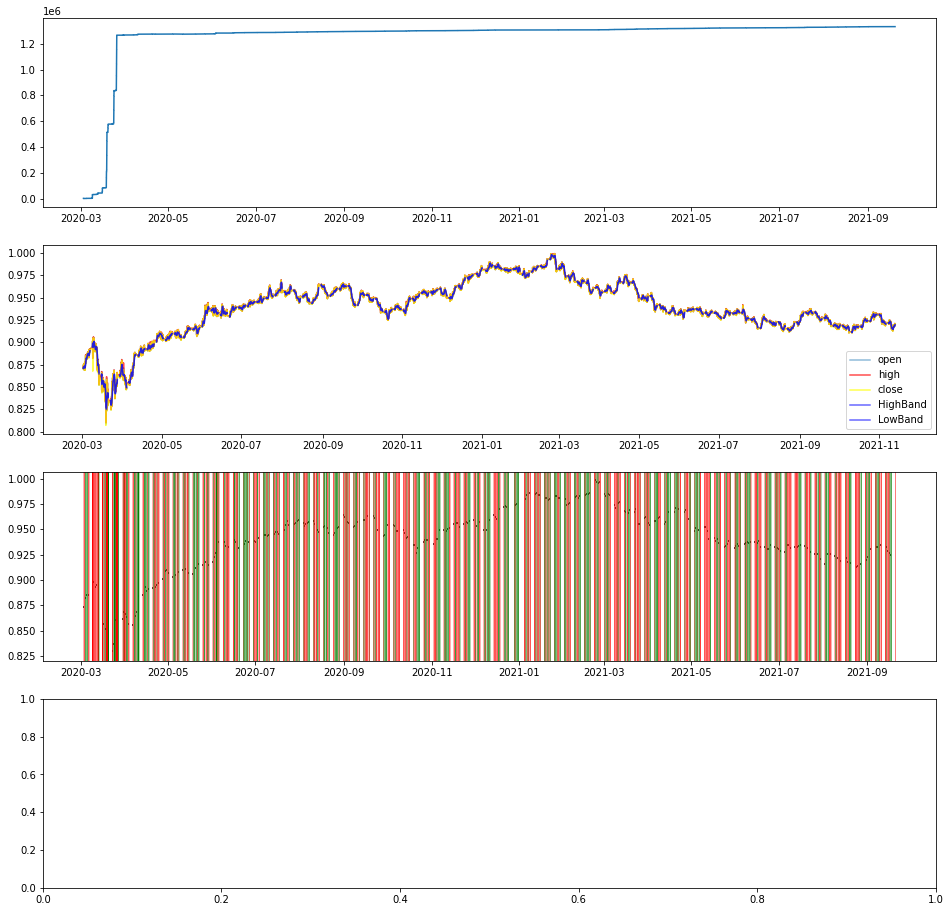

In [87]:
df, preprocessed_data, optimizePar = _estimator(data_frame=inp_data.copy().loc['2020-03':], params_dict=create_grid(dict(optParams)), show=True)
plotter(df, preprocessed_data)

In [89]:
df.head(50)

,type_operation,position,open_price,open_index,stop_loss_border,take_profit_border,open_time,type_holding,close_price,close_index,close_time,profit
close_time,,,,,,,,,,,,
2020-03-03 05:49:00,SELL,-114533.105794,0.87311,1279,0.88184,0.86438,2020-03-02 22:34:00,endPeriod,0.869990,1642,2020-03-03 05:49:00,347.343290
2020-03-03 11:52:00,SELL,-114742.059849,0.87152,1642,0.88024,0.86280,2020-03-03 05:49:00,endPeriod,0.875550,2005,2020-03-03 11:52:00,-472.410501
2020-03-04 05:49:00,BUY,113702.259264,0.87949,2647,0.87070,0.88828,2020-03-03 22:34:00,endPeriod,0.882465,3010,2020-03-04 05:49:00,328.264221
2020-03-04 11:52:00,BUY,113334.995580,0.88234,3010,0.87352,0.89116,2020-03-04 05:49:00,endPeriod,0.882655,3373,2020-03-04 11:52:00,25.700524
2020-03-05 05:49:00,BUY,113022.446258,0.88478,4015,0.87593,0.89363,2020-03-04 22:34:00,endPeriod,0.887200,4378,2020-03-05 05:49:00,263.514320
2020-03-05 11:52:00,BUY,112806.975983,0.88647,4378,0.87761,0.89533,2020-03-05 05:49:00,endPeriod,0.888245,4741,2020-03-05 11:52:00,190.232382
2020-03-06 05:49:00,SELL,-112818.430019,0.88638,5383,0.89524,0.87752,2020-03-05 22:34:00,endPeriod,0.882900,5746,2020-03-06 05:49:00,382.608136
2020-03-06 11:52:00,SELL,-112990.520095,0.88503,5746,0.89388,0.87618,2020-03-06 05:49:00,endPeriod,0.889220,6109,2020-03-06 11:52:00,-483.430279
2020-03-09 04:49:00,SELL,-111740.583062,0.89493,6898,0.90388,0.88598,2020-03-09 00:16:00,takeProfit,0.885980,7171,2020-03-09 04:49:00,990.078218


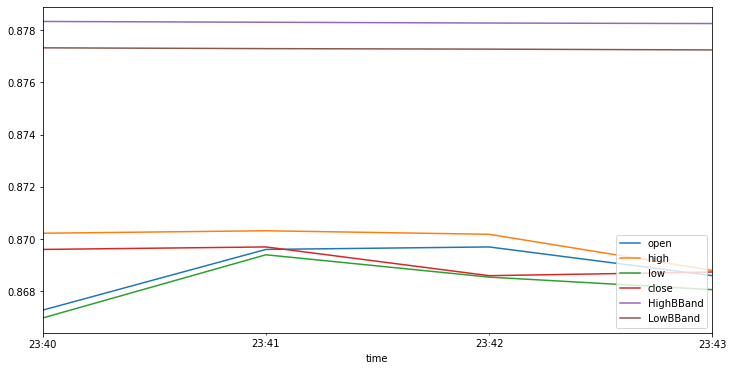

In [117]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)
inp_data.copy().loc['2020-03-12 23:40:00': '2020-03-12 23:43:00'].plot(ax=ax)
preprocessed_data.loc['2020-03-12 23:40:00': '2020-03-12 23:43:00'][['HighBBand', 'LowBBand']].plot(ax=ax)
plt.legend(loc='lower right')




In [120]:
preprocessed_data.loc['2020-03-12 23:40:00': '2020-03-12 23:43:00']

,open,high,low,close,rolling_mean,rolling_std,HighBBand,LowBBand,line_number
time,,,,,,,,,
2020-03-12 23:40:00,0.867275,0.870220,0.866975,0.869600,0.877821,0.005044,0.87833,0.87732,12578
2020-03-12 23:41:00,0.869600,0.870315,0.869395,0.869695,0.877796,0.005038,0.87830,0.87729,12579
2020-03-12 23:42:00,0.869695,0.870180,0.868540,0.868595,0.877770,0.005035,0.87827,0.87727,12580
2020-03-12 23:43:00,0.868595,0.868795,0.868060,0.868735,0.877743,0.005031,0.87825,0.87724,12581


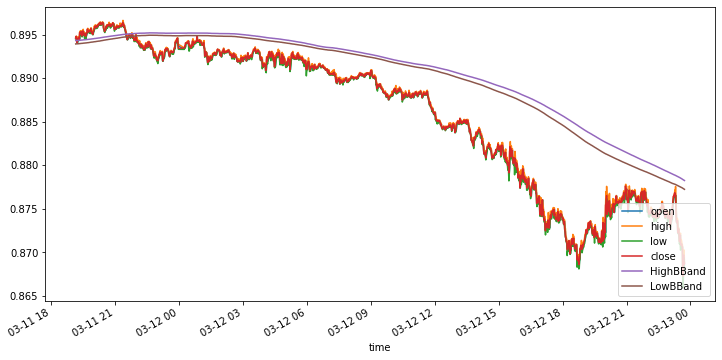

In [124]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)
inp_data.copy().loc['2020-03-11 19:10:00': '2020-03-12 23:43:00'].plot(ax=ax)
preprocessed_data.loc['2020-03-11 19:10:00': '2020-03-12 23:43:00'][['HighBBand', 'LowBBand']].plot(ax=ax)
plt.legend(loc='lower right')